### Hanle Effect Individual Analysis
##### Zachary Banken 4/6/23

In [2]:
# Run this cell with Shift-Enter, and wait until the 
# asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
import uncertainties as unc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Channel to magnetic field conversion function

In [3]:
# Channel to Sweep current conversion

Conversion_const = 14.3 # G / A

Imin = unc.ufloat(-0.200, np.std([0.1965,0.201,0.201,0.201]),'I') #A
Imax = unc.ufloat(0.213, 0.0005, 'I') #A
Ipp = Imax - Imin
dwell = 20e-3 #s
period = 21 #s

# add uncertainty

def current_cal(chan, Ipp=Ipp, dwell=dwell, period=period):
    
    ''' 
    converts channel number to current in A. valid for 0 to 512
    '''
 
    # time = chan * dwell
    # current = (time / (period / 2)) * Ipp - (Ipp / 2)
    #         = chan * (dwell / (period / 2)) * Ipp - (Ipp / 2)
    
    
    # trigger is at negative extreme of waveform
    slope = (dwell / (period / 2)) * Ipp
    intercept = Imin
    
    
    return(intercept + slope * chan) # correction factor?

# Test 

a_channel = 520
print("Current at channel {} = {:4g} A".format(a_channel, current_cal(a_channel)))


Current at channel 520 = 0.2091+/-0.0005 A


### Importing and converting data

Text(0.5, 1.0, 'Hanle Effect (vertical polarization)')

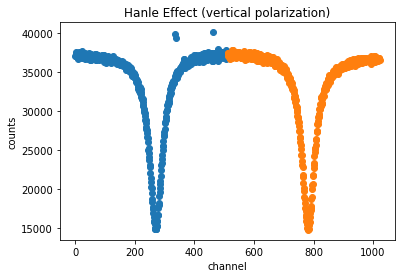

In [4]:
# fitting and plotting data

# created two dataframes to avoid slicing warning
vertical_l = pd.read_csv('vertical.csv', sep='\t', header = 'infer')
vertical_r = pd.read_csv('vertical.csv', sep='\t', header = 'infer')

# left peak
vertical_l = vertical_l[0:512]
vertical_l['current'] = current_cal(vertical_l['channel'])
vertical_l['Bfield'] = Conversion_const * vertical_l['current'] 

# right peak
vertical_r = vertical_r[512:-1]
vertical_r['current'] = current_cal(vertical_r['channel'])
vertical_r['Bfield'] = Conversion_const * vertical_r['current']

plt.scatter(vertical_l['channel'], vertical_l['counts'])
plt.scatter(vertical_r['channel'], vertical_r['counts'])
plt.xlabel('channel')
plt.ylabel('counts')
plt.title('Hanle Effect (vertical polarization)') 


Text(0.5, 1.0, 'Hanle Effect (vertical polarization)')

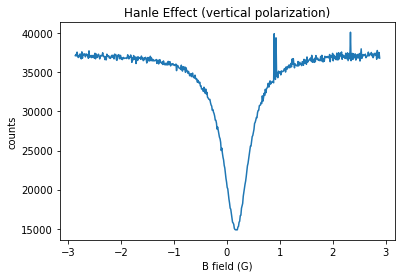

In [5]:
plt.errorbar([x.n for x in vertical_l['Bfield']],vertical_l['counts'], yerr = [x.s for x in vertical_l['Bfield']])
plt.xlabel('B field (G)')
plt.ylabel('counts')
plt.title('Hanle Effect (vertical polarization)')

### Data fitting

In [6]:
# fitting model based on Mossbauer lab example

from lmfit.models import LinearModel, LorentzianModel

def fit_peak_params(center, df=vertical_l, amplitude=-40_000,slope=0,intercept=35_000):
    # create an instance of the model
    # Note use of prefixes to keep parameters separate
    peak = LorentzianModel()
    background = LinearModel()
    model = peak + background

    params = model.make_params()
    
    # set initial parameters by eye
    params['center'].set(value=center, vary=True)
    params['amplitude'].set(value=amplitude, vary=True)
    params['slope'].set(value = slope, vary=True)
    params['intercept'].set(value = intercept, vary=True)

    x = [x.n for x in df['Bfield']]
    y = df['counts']

    model_fit = model.fit(y, params, x=x, weights = 1/np.sqrt(y))

    print(model_fit.fit_report(show_correl=False))

    myfig=plt.figure(figsize=(15,15))
    model_fit.plot(fig=myfig);
    
    return model_fit

[[Model]]
    (Model(lorentzian) + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 512
    # variables        = 5
    chi-square         = 2636.13962
    reduced chi-square = 5.19948643
    Akaike info crit   = 849.038073
    Bayesian info crit = 870.229696
[[Variables]]
    amplitude: -20886.6486 +/- 112.197801 (0.54%) (init = -40000)
    center:     0.17388407 +/- 9.9592e-04 (0.57%) (init = 0)
    sigma:      0.29568079 +/- 0.00175452 (0.59%) (init = 1)
    slope:      51.6478696 +/- 11.7495545 (22.75%) (init = 0)
    intercept:  37419.6483 +/- 26.5222825 (0.07%) (init = 35000)
    fwhm:       0.59136158 +/- 0.00350904 (0.59%) == '2.0000000*sigma'
    height:    -22485.1502 +/- 67.0427490 (0.30%) == '0.3183099*amplitude/max(1e-15, sigma)'


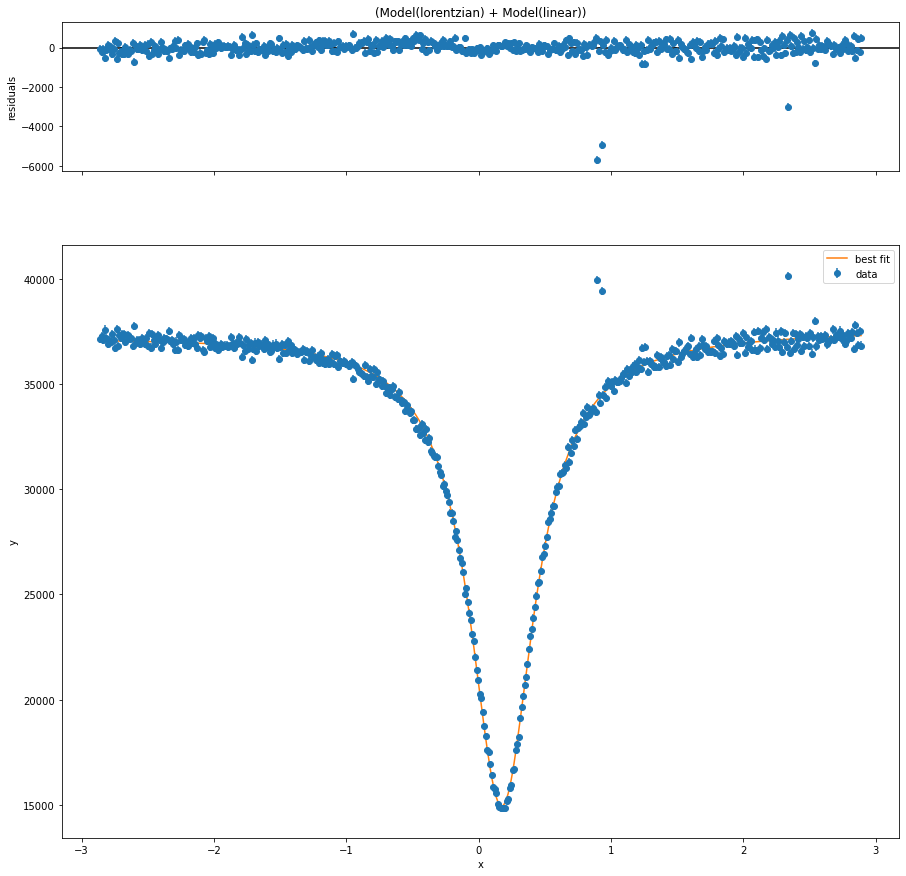

In [7]:
left_peak = fit_peak_params(center = 0, df = vertical_l)

[[Model]]
    (Model(lorentzian) + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 511
    # variables        = 5
    chi-square         = 1231.85802
    reduced chi-square = 2.43450202
    Akaike info crit   = 459.633655
    Bayesian info crit = 480.815503
[[Variables]]
    amplitude: -20361.1023 +/- 75.8695199 (0.37%) (init = -40000)
    center:     5.93251151 +/- 6.8515e-04 (0.01%) (init = 6)
    sigma:      0.29207308 +/- 0.00120526 (0.41%) (init = 1)
    slope:     -147.440057 +/- 8.03647267 (5.45%) (init = 0)
    intercept:  38032.7173 +/- 48.9593481 (0.13%) (init = 35000)
    fwhm:       0.58414617 +/- 0.00241051 (0.41%) == '2.0000000*sigma'
    height:    -22190.1324 +/- 46.1218094 (0.21%) == '0.3183099*amplitude/max(1e-15, sigma)'


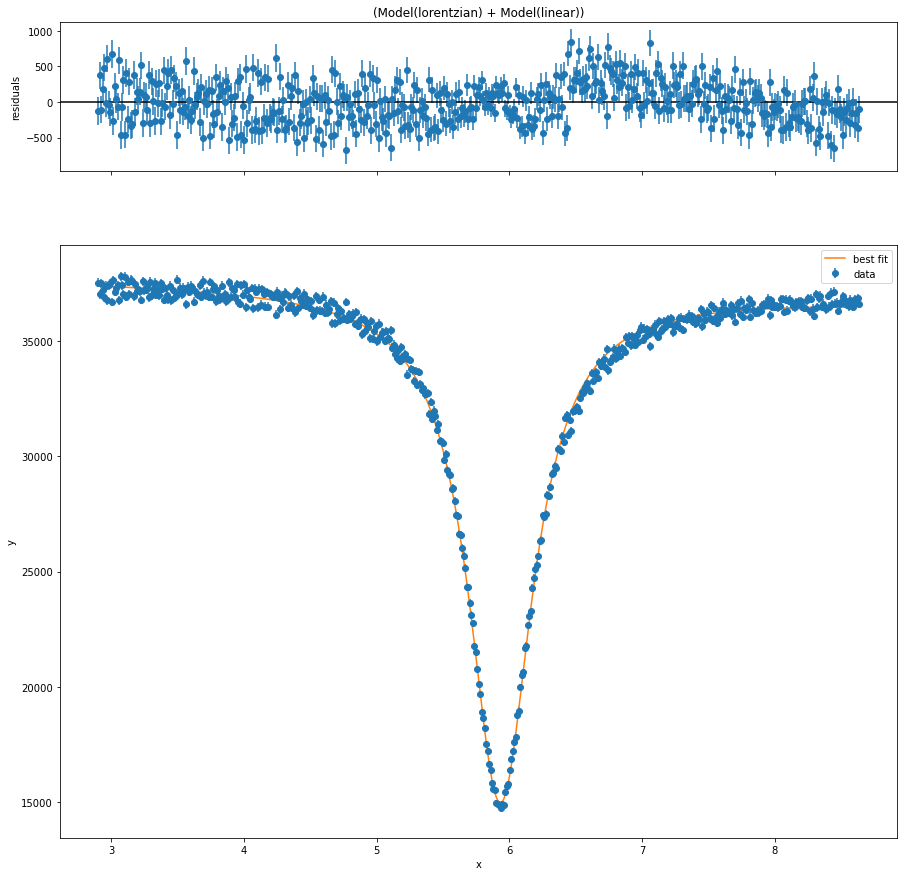

In [8]:
# Note that the right peak does not have the correct x-axis offset 
# (the peak is actually centered around 0). This does not affect the result,
# since we only need the half width at half maximum.
right_peak = fit_peak_params(center = 6, df = vertical_r)

### Lifetime calculation

In [11]:
# lifetime calculation of 3P1 state

# constants
tau_actual = 3e-7
hbar = const.hbar
mu_B = const.physical_constants["Bohr magneton"][0]
g_J = (3/2)

#calculate lifetime based on eq. 4. in experiment instructions
def calculate_lifetime(model_fit):
    fwhm = unc.ufloat(model_fit.params['fwhm'].value, model_fit.params['fwhm'].stderr)
    B_half = fwhm/2
    tau = 1 / ( 2 * g_J * (mu_B / hbar) * (B_half/ 10_000))
    return [B_half, tau]


tau_r = calculate_lifetime(right_peak)[1]
tau_l = calculate_lifetime(left_peak)[1]

Bhalf_r = calculate_lifetime(right_peak)[0]
Bhalf_l = calculate_lifetime(left_peak)[0]

B_half = (Bhalf_r + Bhalf_l)/2
tau = (tau_r + tau_l)/2
print('Bhalf = {:uP} G'.format(B_half))
print('tau = {:uP} s'.format(tau))




Bhalf = 0.2939±0.0011 G
tau = (1.290±0.005)×10⁻⁷ s


In [12]:
#Comparison of two peaks

print('tau right = {:uP} s'.format(tau_r))
print('tau left = {:uP} s'.format(tau_l))

percent_diff = (tau_r - tau_l)/((tau_r + tau_l)/2)*100
print('percent difference = {:uP} %'.format(percent_diff))

tau right = (1.298±0.005)×10⁻⁷ s
tau left = (1.282±0.008)×10⁻⁷ s
percent difference = 1.2±0.7 %


In [58]:
fwhm_percent_unc_right = right_peak.params['fwhm'].stderr / right_peak.params['fwhm'].value  * 100
fwhm_percent_unc_left = left_peak.params['fwhm'].stderr / left_peak.params['fwhm'].value  * 100


print('percent uncertainty in fit FWHM (right) = {:g} %'.format(fwhm_percent_unc_right))
print('percent uncertainty in fit FWHM (left) = {:g} %'.format(fwhm_percent_unc_left))

percent uncertainty in fit FWHM (right) = 0.412656 %
percent uncertainty in fit FWHM (left) = 0.593382 %


### Individual report question 3

Text(0.5, 1.0, 'Hanle Effect (20 degrees off vertical polarization)')

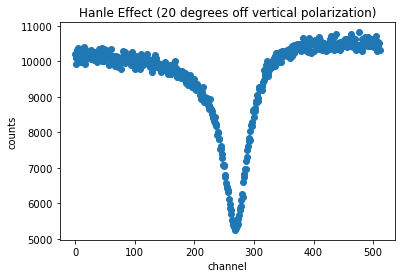

In [21]:
off_vertical_l = pd.read_csv('20degrees.csv', sep='\t', header = 'infer')
off_vertical_l = off_vertical_l[0:512]

off_vertical_l['current'] = current_cal(off_vertical_l['channel'])
off_vertical_l['Bfield'] = Conversion_const * off_vertical_l['current'] 


plt.scatter(off_vertical_l['channel'], off_vertical_l['counts'])
plt.xlabel('channel')
plt.ylabel('counts')
plt.title('Hanle Effect (20 degrees off vertical polarization)') 

[[Model]]
    (Model(lorentzian) + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 107
    # data points      = 512
    # variables        = 5
    chi-square         = 1690.29044
    reduced chi-square = 3.33390619
    Akaike info crit   = 621.497485
    Bayesian info crit = 642.689108
[[Variables]]
    amplitude: -4678.32368 +/- 49.1696239 (1.05%) (init = -40000)
    center:     0.14472299 +/- 0.00203577 (1.41%) (init = 0)
    sigma:      0.29846771 +/- 0.00353996 (1.19%) (init = 1)
    slope:      116.578008 +/- 4.96334695 (4.26%) (init = 0)
    intercept:  10363.2236 +/- 11.3036720 (0.11%) (init = 35000)
    fwhm:       0.59693541 +/- 0.00707992 (1.19%) == '2.0000000*sigma'
    height:    -4989.33958 +/- 31.1499703 (0.62%) == '0.3183099*amplitude/max(1e-15, sigma)'


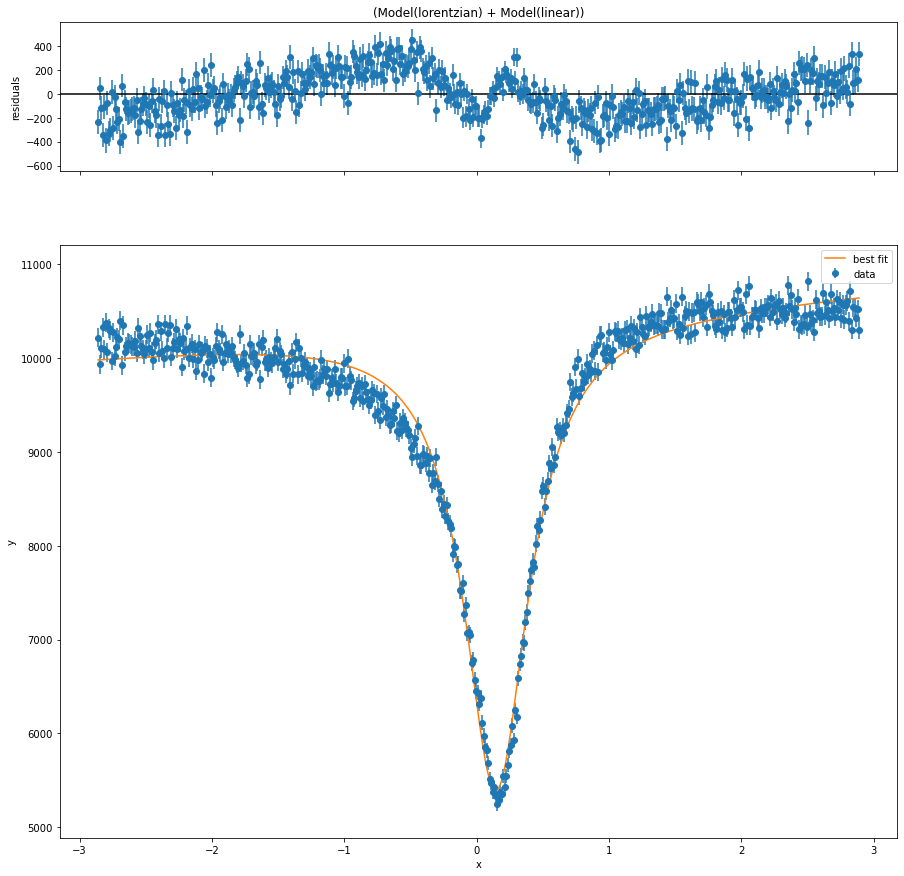

In [22]:
off_vertical_peak = fit_peak_params(center = 0, df = off_vertical_l)

In [27]:
off_vertical_peak.params['fwhm']

<Parameter 'fwhm', value=0.5969354130280777 +/- 0.00708, bounds=[-inf:inf], expr='2.0000000*sigma'>

In [28]:
left_peak.params['fwhm']

<Parameter 'fwhm', value=0.5913615838473172 +/- 0.00351, bounds=[-inf:inf], expr='2.0000000*sigma'>